---
<h1><B> Fraud Analytics (CS6890)  </h1></B></center>

---

<table>
<tr>
<td><h3> Assignment : </td>
<td><h3> 2 </td>
</tr>
<tr>
<td><h3> Title : </td>
<td><h3> Trust Rank Assignment </td>
</tr>
<tr>
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr>
<td><h5> Pramit Sahoo </td>
<td><h5> AI23MTECH14004 </td>
</tr>
<tr>
<td><h5> Tarun Jalota </td>
<td><h5> AI23MTECH13004 </td>
</tr>
<tr>
<td><h5> Pathlavath Shankar </td>
<td><h5> CS21BTECH11064 </td>
</tr>
<tr>
<td><h5> N Sree Harsha </td>
<td><h5> CS21BTECH11042 </td>
</tr>
<tr>
<td><h5> Jayachandra Naidu Rajapu </td>
<td><h5> CS21BTECH11064</td>
</tr>
<tr>


<table>



</td>
</tr>
<table>


## NOTE :
---

## we have used pregel frame work And modified Page rank to implement Trust Rank.




In [1]:
"""pregel.py is a python 2.6 module implementing a toy single-machine
version of Google's Pregel system for large-scale graph processing."""

import collections
import threading
import time

class Vertex():

    def __init__(self,id,value,out_vertices):
        # This is mostly self-explanatory, but has a few quirks:
        #
        # self.id is included mainly because it's described in the
        # Pregel paper.  It is used briefly in the pagerank example,
        # but not in any essential way, and I was tempted to omit it.
        #
        # Each vertex stores the current superstep number in
        # self.superstep.  It's arguably not wise to store many copies
        # of global state in instance variables, but Pregel's
        # synchronous nature lets us get away with it.
        self.id = id
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

class Pregel():

    def __init__(self,vertices,num_workers):
        self.vertices = vertices
        self.num_workers = num_workers

    def run(self):
        """Runs the Pregel instance."""
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_messages()

    def partition_vertices(self):
        """Returns a dict with keys 0,...,self.num_workers-1
        representing the worker threads.  The corresponding values are
        lists of vertices assigned to that worker."""
        partition = collections.defaultdict(list)
        for vertex in self.vertices:
            partition[self.worker(vertex)].append(vertex)
        return partition

    def worker(self,vertex):
        """Returns the id of the worker that vertex is assigned to."""
        return hash(vertex) % self.num_workers

    def superstep(self):
        """Completes a single superstep.

        Note that in this implementation, worker threads are spawned,
        and then destroyed during each superstep.  This creation and
        destruction causes some overhead, and it would be better to
        make the workers persistent, and to use a locking mechanism to
        synchronize.  The Pregel paper suggests that this is how
        Google's Pregel implementation works."""
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            #print(f" Worker started with vertices list : {[v.id for v in vertex_list]}")
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """Updates the message lists for all vertices."""
        for vertex in self.vertices:
            vertex.superstep +=1
            vertex.incoming_messages = []
        for vertex in self.vertices:
            for (receiving_vertix,message) in vertex.outgoing_messages:
                receiving_vertix.incoming_messages.append((vertex,message))

    def check_active(self):
        """Returns True if there are any active vertices, and False
        otherwise."""
        return any([vertex.active for vertex in self.vertices])

class Worker(threading.Thread):

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()
        #time.sleep(10)
        #print(f" Worker completed superstep with vertices list : {[v.id for v in self.vertices]}")


    def superstep(self):
        """Completes a single superstep for all the vertices in
        self."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()


<h1>TrustRank</h1>

In [2]:
# Importing Lib
import numpy as np
from numpy import mat
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
# from pregel import Vertex, Pregel # do not need since IPYNB
from tqdm import tqdm

# Defining Number of workers
num_workers = 10

In [3]:
# Difined global color
CLR = (199, 25, 24)
CLR = [x/255 for x in CLR]

In [4]:
# Custom Vertex class which extends the pregal vertex
class TrustRankVertex(Vertex):
  def __init__(self,id,value,out_vertices,dampingFactor=0.85,iterations=50):
    Vertex.__init__(self,id,value,out_vertices)
    self.dampingFactor = dampingFactor
    self.num_supersteps = iterations

  def update(self):
    """
      This is a update Function call by the pregal framework.
    """
    # check is no. of super steps are exosted.
    if self.superstep < self.num_supersteps:
        # sum over incoming message / incoming bad score
        messages_sum = 0
        for (vertex,message) in self.incoming_messages:
            messages_sum = messages_sum + message

        # Update currunt value as similar to page rank algo
        if self.id in Bad_Senders_Id:
          self.value = (1-self.dampingFactor) / BN + self.dampingFactor*messages_sum
        else:
          self.value = self.dampingFactor*messages_sum
        Total = 0
        # Update outgoing bad score as per trade fraction with each on the outgoing edges
        for vertex,Amt in self.out_vertices:
          Total += Amt
        self.outgoing_messages = [(vertex,(self.value * (Amt/Total))) for vertex,Amt in self.out_vertices]
    else:
        self.active = False

In [5]:
def ReadData(path):
  # Read data from csv
  df = pd.read_csv(path)
  Data = df.values
  print("Loded data of shape : ",Data.shape)
  return Data

def IntialTrustRankScore(DistinctVertexSet,Bad_Senders):
  # Initialize the vertices
  return [1.0/len(Bad_Senders) if (n in Bad_Senders) else 0.0 for n in DistinctVertexSet]

def UpdateOutGoingVertices(vertices,Edges):
  # Add the outgoing vertices to each vertex based on the directed edges between them
  F = True
  # Iter all edges
  for frm,to,amt in tqdm(Edges):
    F = True
    # add edge in O(N^2)
    for v in vertices:
        for u in vertices:
            if v.id == frm and u.id == to:
                v.out_vertices.append((u,amt))
                F = False
                break
        if not F:
          break;

def pregelTrustRank(vertices):
    # Trust rank run
    p = Pregel(vertices,num_workers)
    p.run()
    return mat([vertex.value for vertex in p.vertices]).transpose()

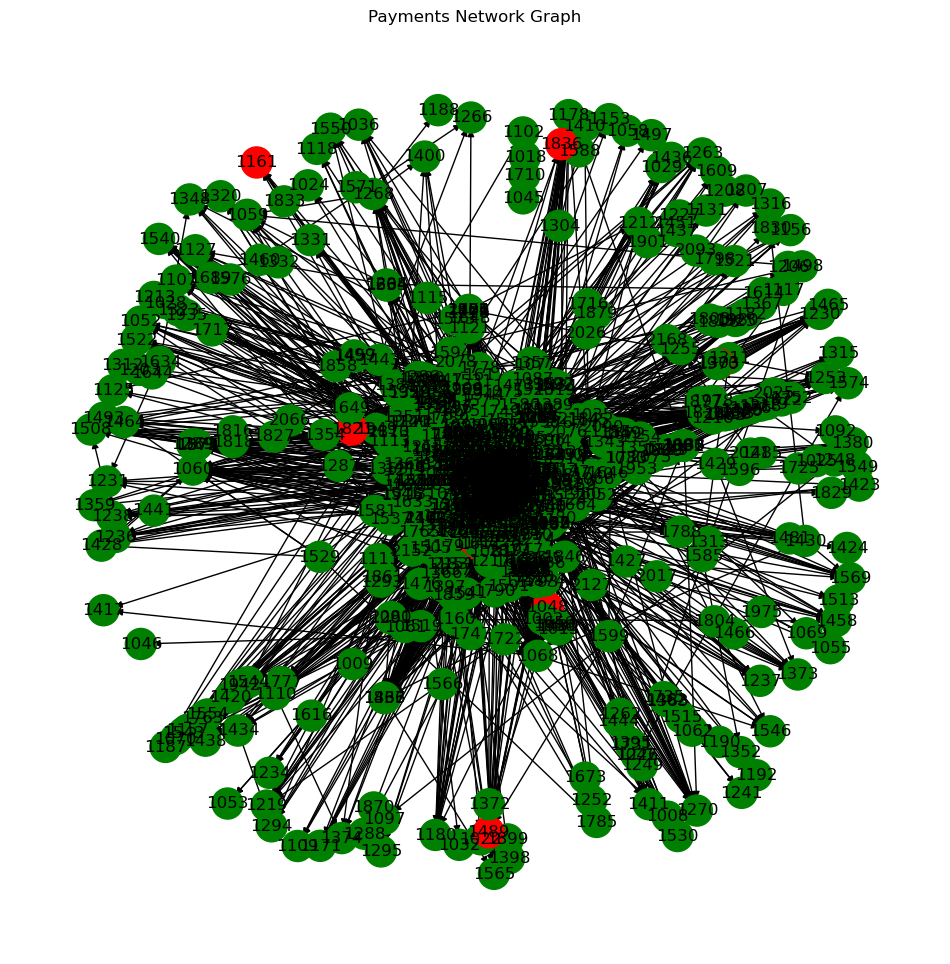

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import csv

def read_data(filepath):
    """Read CSV data from the given filepath, skipping the header row."""
    with open(filepath, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        return list(reader)

# Load the data
payments = read_data('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment 2/Payments.csv')
bad_senders = read_data('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment 2/bad_sender.csv')
bad_sender_ids = {int(row[0]) for row in bad_senders if row[0].isdigit()}

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for sender, receiver, amount in payments:
    sender, receiver, amount = int(sender), int(receiver), float(amount)
    if (sender, receiver) not in G.edges:
        G.add_edge(sender, receiver, weight=amount)
    else:
        G[sender][receiver]['weight'] += amount

# Define node color
node_color = ['red' if node in bad_sender_ids else 'green' for node in G.nodes()]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Payments Network Graph')
plt.axis('off')  # Turn off the axis
plt.show()


In [9]:
# Read Payments data
payments = ReadData('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment 2/Payments.csv')
# Read bad_sender Data
bad_senders = ReadData('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment 2/bad_sender.csv')

# Defined Set of Unique Vetices and Edges
DistinctVertexSet = set()
Edges = set()

# Created Set of Unique Vetices and Edges
for Data in payments:
    DistinctVertexSet.add(int(Data[0]))
    DistinctVertexSet.add(int(Data[1]))
    Edges.add((int(Data[0]),int(Data[1])))

# Created Total transetion dict as sum of all transection between 2 DistinctVertexSet
Amount = {}
for Data in payments:
  if (int(Data[0]),int(Data[1])) in Amount:
    Amount[(int(Data[0]),int(Data[1]))] += Data[2]
  else:
    Amount[(int(Data[0]),int(Data[1]))] = Data[2]

# Converted set to list
DistinctVertexSet = list(DistinctVertexSet)
Edges = list(Edges)

# found total Vertices
N = len(DistinctVertexSet)


# Some temp data of bad senders stored to add new set of edges later
Bad_Senders_Ind = []
Bad_Senders_Id = []
for Data in bad_senders:
    Bad_Senders_Ind.append(DistinctVertexSet.index(Data[0]))
    Bad_Senders_Id.append(Data[0])
BN = len(Bad_Senders_Id)
# Found the initial weights of the nodes
DistinctVertexSet_intial_ranks = IntialTrustRankScore(DistinctVertexSet,bad_senders)

print("Total Delars : ",N)

# Created N vertices of type TrustRankVertex
vertices = []
for i in range(len(DistinctVertexSet)):
    vertices.append(TrustRankVertex(DistinctVertexSet[i],DistinctVertexSet_intial_ranks[i],[],0.85,50))

Loded data of shape :  (130535, 3)
Loded data of shape :  (20, 1)
Total Delars :  799


In [10]:
# Count Outgoing vertices
CountOutVer = [0] * 799
for frm,to in Edges:
  CountOutVer[DistinctVertexSet.index(frm)] += 1

# Add Outgoing edges where there is no outgoing edges
# Connect then to all the bad nodes
NewEdges = []
for j,i in enumerate(CountOutVer):
  if i == 0:
    for Bi in Bad_Senders_Id:
      ind = DistinctVertexSet[j]
      NewEdges.append((ind,Bi))

# Created a Final List of edges with appropriate fraction
FinalEdges = []
for edge in Edges:
  FinalEdges.append((edge[0],edge[1],Amount[edge]))
for edge in NewEdges:
  FinalEdges.append((edge[0],edge[1],1/len(Bad_Senders_Id)))

print(len(Edges),len(NewEdges),len(FinalEdges))

5358 1920 7278


In [11]:
#Updating vertex out vertices to send the messages
print("Updating OutGoing Vertices...")
UpdateOutGoingVertices(vertices,FinalEdges)
print("Running Trust Rank...")
node_ranks = pregelTrustRank(vertices)

Updating OutGoing Vertices...


100%|██████████| 7278/7278 [00:40<00:00, 178.34it/s]


Running Trust Rank...


In [12]:
colors = []
for i in DistinctVertexSet:
  # print(i)
  if i in Bad_Senders_Id:
    colors.append(1)
  else:
    colors.append(0)


In [13]:
# To verify that network sum to ~ 1
sum(node_ranks)

matrix([[0.99970424]])

In [14]:
# Plot Data

# to Plot X axis data
X = list(range(1,len(node_ranks)+1))
# Xx = X[::-1]
plotdata = [val[0].item() for i,val in enumerate(node_ranks)]
plotdata1 = np.asarray(tuple(zip(plotdata,colors)))
plotdata1  = plotdata1[plotdata1[:, 0].argsort()]
plotdata1 = plotdata1[::-1]
plotdata2 = []
for i,val in enumerate(plotdata1):
  plotdata2.append((i,plotdata1[i,1]))
plotdata2 = np.asarray(plotdata2)

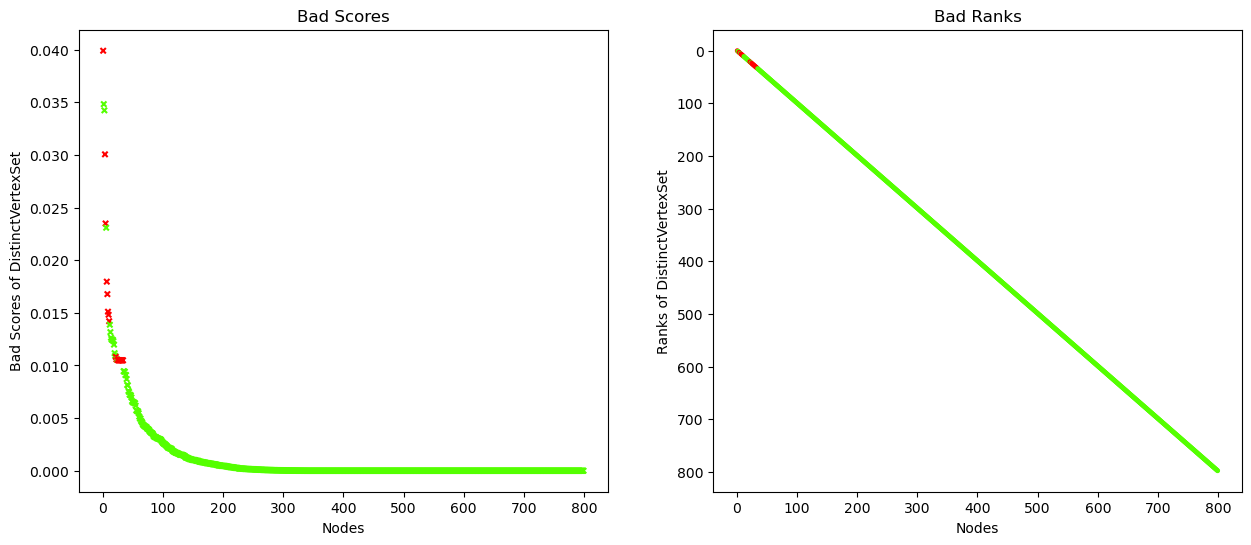

<Figure size 640x480 with 0 Axes>

In [15]:
# Plotting the graph
#  Trust Rank
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

ax1.scatter(X,plotdata1[:,0],s=15,marker='x',c=plotdata1[:,1],cmap='prism_r')
ax1.set_title("Bad Scores")
ax1.set_xlabel("Nodes")
ax1.set_ylabel("Bad Scores of DistinctVertexSet")

ax2.scatter(X,plotdata2[:,0],s=25,marker='.',c=plotdata2[:,1],cmap='prism_r')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_title("Bad Ranks")
ax2.set_xlabel("Nodes")
ax2.set_ylabel("Ranks of DistinctVertexSet")

plt.show()
# plt.savefig('Picture 1.png')


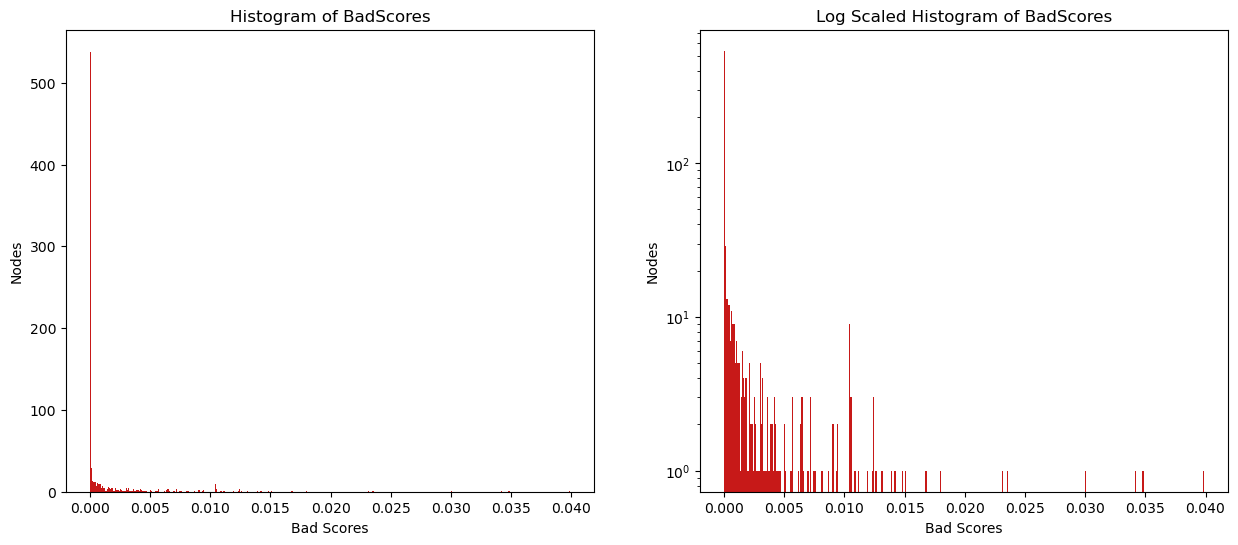

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.hist(plotdata1[:,0],bins='auto',color=CLR)
# ax1.scatter(X,plotdata1[:,0],s=15,marker='x',c=plotdata1[:,1],cmap='prism_r')
ax1.set_title("Histogram of BadScores")
ax1.set_xlabel("Bad Scores")
ax1.set_ylabel("Nodes")

# ax2.scatter(X,plotdata2[:,0],s=25,marker='.',c=plotdata2[:,1],cmap='prism_r')
ax2.hist(plotdata1[:,0],bins='auto',color=CLR)
ax2.set_yscale('log')
ax2.set_title("Log Scaled Histogram of BadScores")
ax2.set_xlabel("Bad Scores")
ax2.set_ylabel("Nodes")

plt.show()

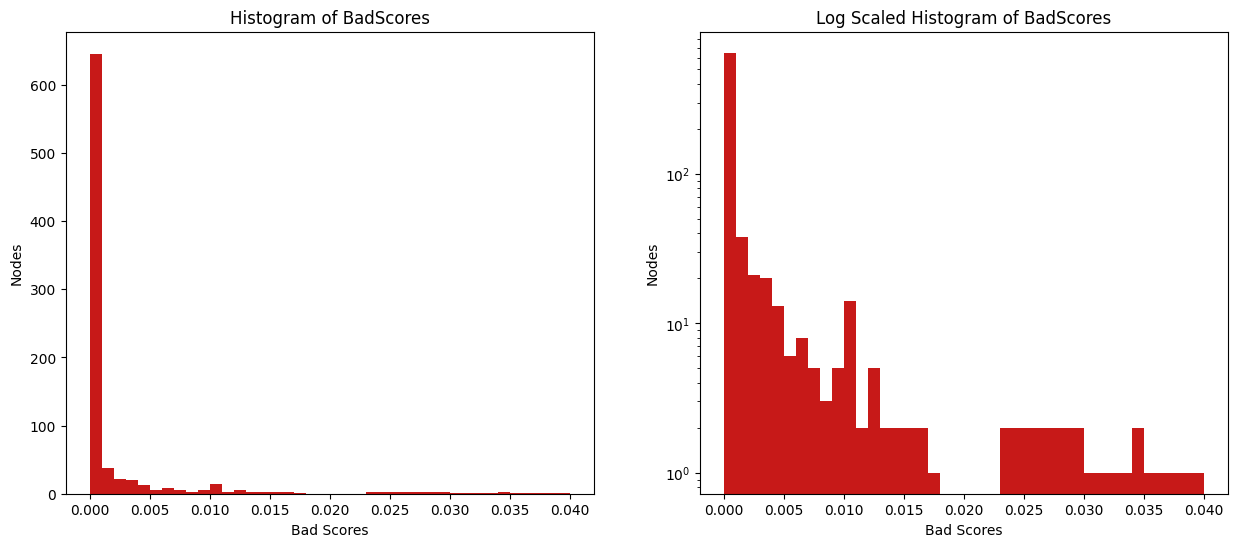

In [16]:
# Plotting the graph
# Histogram

bin = set()
for val in plotdata1[:,0]:
  bin.add(round(val,3))
bin = list(bin)
bin.sort()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.hist(plotdata1[:,0],bins=bin,color=CLR)
# ax1.scatter(X,plotdata1[:,0],s=15,marker='x',c=plotdata1[:,1],cmap='prism_r')
ax1.set_title("Histogram of BadScores")
ax1.set_xlabel("Bad Scores")
ax1.set_ylabel("Nodes")

# ax2.scatter(X,plotdata2[:,0],s=25,marker='.',c=plotdata2[:,1],cmap='prism_r')
ax2.hist(plotdata1[:,0],bins=bin,color=CLR)
ax2.set_yscale('log')
ax2.set_title("Log Scaled Histogram of BadScores")
ax2.set_xlabel("Bad Scores")
ax2.set_ylabel("Nodes")

plt.show()




<h1> Some Extra Code to Generate Graph for the Report

19
[1076, 1243, 1049, 1163, 1328, 1088, 1101, 1037, 1510, 1569, 1074, 1199, 1430, 1201, 1003, 1676, 1007, 1075, 1112]
[0, 4263479, 2773229, 29664, 16388, 1007452, 1724624, 3000, 31107, 27510, 20171, 227251, 570768, 168201, 63602, 28833, 6286829, 3897038, 1853485]
(19, 19)
(19, 19)
[0.016779145873266794, 0.004390820711741152, 0.006415654838769877, 0.0015485445560963276, 0.0037138985997331674, 0.03483266616262363, 0.002666421195840292, 0.007149569264576158, 1.929539269926109e-05, 0.0011006591562030868, 0.006182359212549388, 0.0027534577297688525, 0.0012575001996529191, 0.012634332129078328, 0.0003660560342947884, 0.0008472059619241177, 0.039906261044211015, 0.0034114872629038328, 0.0030681513963893414]


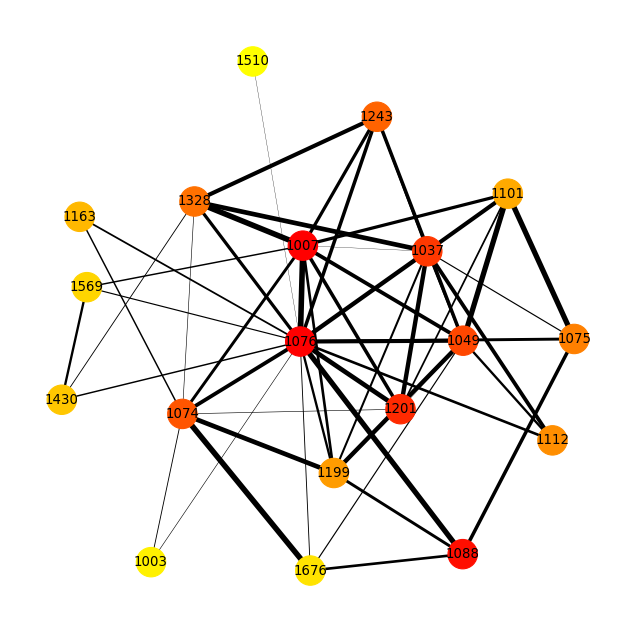

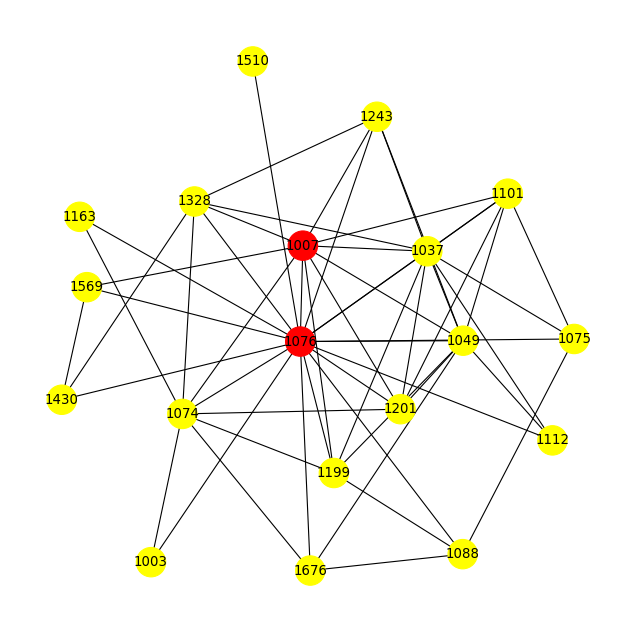

18

In [17]:
from matplotlib import pylab
import networkx as nx

def save_graph(graph,file_name,clrmap,edgemap,newGid,pos):
  # color_map = [(val-min(plotdata2[:,2]))/(max(plotdata2[:,2])-min(plotdata2[:,2])) for val in plotdata2[:,2]]

  #initialze Figure
  plt.figure(num=None, figsize=(10, 10), dpi=80)
  plt.axis('off')
  fig = plt.figure(1)
  # pos = nx.spectral_layout(graph)
  # pos = nx.spring_layout(graph)
  # pos = nx.kamada_kawai_layout(graph)
  nx.draw_networkx_edges(graph,pos,width=edgemap,alpha= 1)
  nx.draw_networkx_nodes(graph,pos,node_color= clrmap ,cmap='autumn_r',label=newGid,node_size=700)
  nx.draw_networkx_labels(graph,pos,newGid)

  cut = 1.00
  xmax = cut * max(xx for xx, yy in pos.values())
  ymax = cut * max(yy for xx, yy in pos.values())
  # plt.xlim(0, xmax)
  # plt.ylim(0, ymax)
  plt.show()
  # plt.savefig(file_name,bbox_inches="tight")
  pylab.close()
  del fig


Point = None
for vertex in vertices:
  if vertex.id == 1076:
    Point = vertex

newG = []
newGid = []
Amts = []

newG.append(Point)
newGid.append(Point.id)
Amts.append(0)

for ver,amt in Point.out_vertices:
# for ver in vertices:
  newG.append(ver)
  newGid.append(ver.id)
  Amts.append(amt)

Nn = len(newG)
print(Nn)
print(newGid)
print(Amts)

#Assuming that the graph g has DistinctVertexSet and edges entered

adjacency_matrix = np.zeros((Nn,Nn))

# for v in (Point.out_vertices):
#   v1,v2 = newGid.index(Point.id),newGid.index(v[0].id)
#   adjacency_matrix[v1][v2] = adjacency_matrix[v2][v1] = 1

for vertex in newG:
  for v in (vertex.out_vertices):
    if vertex.id in newGid and v[0].id in newGid:
      v1,v2 = newGid.index(vertex.id),newGid.index(v[0].id)
      adjacency_matrix[v1][v2] = adjacency_matrix[v2][v1] = 1
print(adjacency_matrix.shape)


R, C = np.where(adjacency_matrix == 1)

rows , cols = [],[]
for i in range(len(R)):
  if R[i] != C[i]:
    rows.append(R[i])
    cols.append(C[i])

edges = zip(rows, cols)
G = nx.Graph()
G.add_edges_from(edges)
print(adjacency_matrix.shape)
Ranks = [node_ranks[DistinctVertexSet.index(id)].item() for id in newGid]
print(Ranks)
Ranks = [((val-min(Ranks))/(max(Ranks)-min(Ranks)),i) for i,val in enumerate(Ranks)]
Ranks.sort()
Ranks = [((i+1)/Nn,Ranks[i][1]) for i,val in enumerate(Ranks)]
Ranks.sort(key=lambda x: x[1])
clrmap = [0] *( Nn-1)
clrmap[0] = 1
Ranks = np.asarray(Ranks)
dict1= {}
for ind,i in enumerate(newGid):
  dict1[ind] = i
edgemap = [i * 5 for i in Ranks[1:,0]]
edgemap1 = [1 for i in Ranks[1:,0]]
clrmap1 = [1 if i in Bad_Senders_Id else 0 for i in newGid]

Ranks[0,0] = 1
# clrmap1[0] = 1
pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
save_graph(G,"my_graph.pdf", Ranks[:,0],edgemap,dict1,pos)
save_graph(G,"my_graph_n.pdf", clrmap1,edgemap1,dict1,pos)

len(edgemap)

In [18]:
# D = list(zip(Ranks[:,0],newGid))
# D.sort()
# D
for t in Bad_Senders_Id:
  Point = None
  for vertex in vertices:
    if vertex.id == t:
      Point = vertex

  newG = []
  newGid = []
  Amts = []

  newG.append(Point)
  newGid.append(Point.id)
  Amts.append(0)

  for ver,amt in Point.out_vertices:
    newG.append(ver)
    newGid.append(ver.id)
    Amts.append(amt)

  Nn = len(newG)
  print(t,Nn)

1303 2
1259 31
1562 41
1147 63
1393 4
1031 7
1210 7
1042 6
1048 3
1256 10
1668 21
1161 21
1007 57
1034 49
1836 21
1099 37
1489 21
1821 5
1076 19
1944 18
